# Workspace setup

In [1]:
import os
import urllib
import zipfile
import itertools
import gc
from pathlib import Path
import numpy as np
import pandas as pd
from scipy import stats
import dask.array as da
import dask.dataframe as dd
from dask.diagnostics import ProgressBar
import shapefile
from shapely.geometry import Polygon
from descartes.patch import PolygonPatch
from matplotlib import pyplot as plt
from matplotlib import style
import seaborn as sns
style.use('ggplot')

PARENT_DIR = Path().resolve().parents[0] 
DATA_DIR = PARENT_DIR / 'data'
DATA_URL = 'https://s3.amazonaws.com/nyc-tlc/trip+data/'

companies = ['yellow_trip']
data_suffix = 'data'
years = ['2017']
months = ['03', '06', '11']
dates = ['-'.join([y,m]) for y, m in itertools.product(years, months)]

taxi_data_csv_names = [c + data_suffix + '_' + d + '.csv' for c, d in itertools.product(companies, dates)]
taxi_data_pattern = DATA_DIR / (r'*data_*-*.csv')
csv_urls = [DATA_URL + f for f in taxi_data_csv_names]
csv_files = [DATA_DIR / f for f in taxi_data_csv_names]
csv_dict = dict(zip(taxi_data_csv_names, zip(csv_urls, csv_files)))
parquet_name = DATA_DIR / 'yellow_tripdata_2017-030611.parquet'

lookup_name = DATA_DIR / 'taxi_zone_lookup.csv'
shapefile_name = DATA_DIR / 'taxi_zones.zip'

numerical_cols = ['passenger_count', 'trip_distance', 'fare_amount',
                  'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 
                  'improvement_surcharge', 'total_amount']

categorical_cols = ['VendorID', 'RatecodeID',
                    'store_and_fwd_flag', 'payment_type']

location_cols = ['PULocationID', 'DOLocationID']

datetime_cols = ['tpep_pickup_datetime', 'tpep_dropoff_datetime']

# Downloading data

In [2]:
def dwnld_data(csv_name):
    ''' Downloads file from the url and save it as filename '''
    # check if file already exists
    url, filename = csv_dict[csv_name]
    if not filename.exists():
        print(f'Downloading {csv_name}')
        urllib.request.urlretrieve(url, filename)
    else:
        print(f'{csv_name} exists')

def dwnl_location_lookup():
    url = 'https://s3.amazonaws.com/nyc-tlc/misc/taxi+_zone_lookup.csv'
    filename = lookup_name
    if not filename.exists():
        print('Downloading lookup table')
        urllib.request.urlretrieve(url, filename)
    else:
        print('Lookup table exists')

def dwnl_extract_shapefiles():
    url = 'https://s3.amazonaws.com/nyc-tlc/misc/taxi_zones.zip'
    filename = shapefile_name
    base_dir = DATA_DIR
    if not filename.exists():
        print('Downloading shapefiles')
        urllib.request.urlretrieve(url, filename)
    else:
        print('Shapefile exists')
    print('Extracting shapefile')
    filezip = zipfile.ZipFile(filename, 'r')
    filezip.extractall(base_dir)

In [3]:
%%time
for f in taxi_data_csv_names:
    dwnld_data(f)

dwnl_location_lookup()
dwnl_extract_shapefiles()

yellow_tripdata_2017-03.csv exists
yellow_tripdata_2017-06.csv exists
yellow_tripdata_2017-11.csv exists
Lookup table exists
Shapefile exists
Extracting shapefile
CPU times: user 30.2 ms, sys: 9.41 ms, total: 39.6 ms
Wall time: 57.2 ms


# Optimizing data IO
Dask reads (and concatenates) data sources from 

In [4]:
def write_parquet():
    df = dd.read_csv(taxi_data_pattern, delimiter=',')
    df_initial_n_rows = df.shape[0]

    # Drop rows with all entries equal to NAN
    df = df.dropna('all')

    df.store_and_fwd_flag = df.store_and_fwd_flag.replace({'Y': 1, 'N': 0})
    df[categorical_cols] = df[categorical_cols].astype('uint8')
    df[location_cols] = df[location_cols].astype('uint16')
    df[datetime_cols] = df[datetime_cols].astype('M8[us]')
    df[numerical_cols] = df[numerical_cols].astype('float32')
    df.passenger_count = df.passenger_count.astype('uint8')
    
    if not parquet_name.exists():
        print('Saving parquet file')
        with ProgressBar():
            df.to_parquet(parquet_name, compression='snappy')
    else:
        print('Parquet file already exists')

* Will start by discarding anomalous data records (we will explore them below)

In [5]:
write_parquet()

Parquet file already exists


In [6]:
def load_data(filter_anomalous=True):
    df = dd.read_parquet(parquet_name)
    if filter_anomalous:
        filter_zero_fare = df.fare_amount == 0
        df_zero_fare = df.loc[filter_zero_fare]
        
        # Change it to anomalous by schema
        filter_neg_num = (df[numerical_cols] < 0).any(axis=1)
        df_neg = df.loc[filter_neg_num]

        df = df.loc[~(filter_neg_num | filter_zero_fare)]
        df = df.reset_index(drop=True)
        
        return df, df_zero_fare, df_neg
    else: return df

In [7]:
%%time
df, df_zero_fare, df_neg = load_data()

In [8]:
with ProgressBar():
    display(df.head())
gc.collect();

[########################################] | 100% Completed |  0.3s


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,2,2017-03-09 21:30:11,2017-03-09 21:44:20,1,4.06,1,0,148,48,1,14.0,0.5,0.5,3.06,0.0,0.3,18.360001
1,2,2017-03-09 21:47:00,2017-03-09 21:58:01,1,2.73,1,0,48,107,2,11.5,0.5,0.5,0.00,0.0,0.3,12.800000
2,2,2017-03-09 22:01:08,2017-03-09 22:11:16,1,2.27,1,0,79,162,1,10.0,0.5,0.5,2.82,0.0,0.3,14.120000
3,2,2017-03-09 22:16:05,2017-03-10 06:26:11,1,3.86,1,0,237,41,1,12.0,0.5,0.5,3.99,0.0,0.3,17.290001
4,2,2017-03-31 06:31:53,2017-03-31 06:41:48,1,3.45,1,0,41,162,2,12.0,0.5,0.5,0.00,0.0,0.3,13.300000


In [10]:
df_n_cols = df.shape[1]
df_n_rows = df.shape[0]

df_nans_any = df.isna().any(axis=1)
df_nans_any_n_rows = df_nans_any.sum()

df_zero_fare_n_rows = df_zero_fare.shape[0]
df_neg_n_rows = df_neg.shape[0]

with ProgressBar():
    df_n_rows = df_n_rows.compute()
    df_nans_any_n_rows = df_nans_any_n_rows.compute()
    df_neg_n_rows = df_neg_n_rows.compute()
    df_zero_fare_n_rows = df_zero_fare_n_rows.compute()

df_initial_n_rows = (df_n_rows + df_nans_any_n_rows + df_neg_n_rows + df_zero_fare_n_rows)
kept_rows_ratio = df_n_rows/df_initial_n_rows

print(f'Data shape: {df_n_rows:,} rows and {df_n_cols} columns')
print(f'Keeping {kept_rows_ratio:.2%} of the data')
print(f'\tRows with NAN entries: {df_nans_any_n_rows:,}')
print(f'\tRows with fare equal zero: {df_zero_fare_n_rows:,}')
print(f'\tRows with negative numerical data: {df_neg_n_rows:,}')
gc.collect();

[########################################] | 100% Completed |  3.3s
[########################################] | 100% Completed |  3.5s
[########################################] | 100% Completed |  2.4s
[########################################] | 100% Completed |  2.0s
Data shape: 29,213,507 rows and 17 columns
Keeping 99.92% of the data
	Rows with NAN entries: 0
	Rows with fare equal zero: 8,840
	Rows with negative numerical data: 14,078


# Exploration of numerical variables

We start the analysis of numerical variables by looking at a high level description of the numerical data.

5 and 95 percentiles cut-offs values are included to better asses the presence of otliers.

In [13]:
df_num_description = df[numerical_cols].describe(percentiles = [.01, 0.9,
                                                                .25, .5, .75,
                                                                .91, .99])
with ProgressBar():
    df_num_description = df_num_description.compute()
gc.collect();
df_num_description.T

[########################################] | 100% Completed |  7.0s


,count,mean,std,min,1%,25%,50%,75%,90%,91%,99%,max
passenger_count,29213507.0,1.617754,1.260941,0.00,1.00,1.00,1.00,2.000000,4.000000,5.000000,6.000000,192.000000
trip_distance,29213507.0,2.920356,4.474431,0.00,0.22,1.06,1.81,3.470000,7.690000,8.840000,19.757900,9496.980469
fare_amount,29213507.0,13.122061,147.290085,0.01,3.50,7.50,11.00,18.500000,27.500000,33.000000,56.000000,630461.812500
extra,29213507.0,0.334398,0.460525,0.00,0.00,0.00,0.50,0.500000,1.000000,1.000000,1.000000,69.800003
mta_tax,29213507.0,0.497883,0.034284,0.00,0.50,0.50,0.50,0.500000,0.500000,0.500000,0.500000,53.799999
tip_amount,29213507.0,1.874773,2.631154,0.00,0.00,0.00,1.55,2.960000,4.650000,5.460000,13.170000,450.000000
tolls_amount,29213507.0,0.328758,1.956725,0.00,0.00,0.00,0.00,0.000000,0.000000,0.000000,5.760000,1018.950012
improvement_surcharge,29213507.0,0.299956,0.003728,0.00,0.30,0.30,0.30,0.300000,0.300000,0.300000,0.300000,1.000000
total_amount,29213507.0,16.461704,147.532593,0.01,4.80,9.36,14.12,22.299999,34.299999,40.560001,75.410004,630463.125000


There are clear outliers in the data. Some of these are clearly errors:

* 192 passengers
* ~9,500 mile trip  (almost 3 times the coast to coast distance in the US)
* \> half a million dollar trip

Others seem realistic, yet might be correlated to these. We

[########################################] | 100% Completed |  3.2s


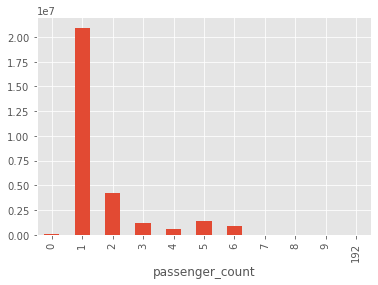

In [12]:
passenger_count_hist = df.groupby('passenger_count').size()
with ProgressBar():
    passenger_count_hist = passenger_count_hist.compute()

passenger_count_hist.sort_index().plot(kind='bar');

[########################################] | 100% Completed |  3.4s


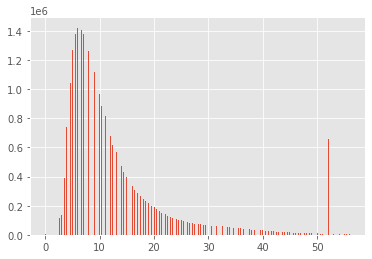

In [20]:
fare_99pct = df_num_description.fare_amount.loc['99%']
fare_counts, fare_bins  = da.histogram(df.fare_amount.values, bins=250, range=[0, fare_99pct])
fare_width = 0.7 * (fare_bins[1] - fare_bins[0])
fare_bins_center = (fare_bins[:-1] + fare_bins[1:]) / 2

with ProgressBar():
    fare_counts = fare_counts.compute()

plt.bar(fare_bins_center, fare_counts, align='center', width=fare_width);

In [25]:
df_tolls_counts, df_tolls_bins  = da.histogram(df.tolls_amount.values, bins=100, range=[0, 20])
tolls_width = 0.7 * (df_tolls_bins[1] - df_tolls_bins[0])
tolls_center = (df_tolls_bins[:-1] + df_tolls_bins[1:]) / 2

with ProgressBar():
    df_tolls_counts = df_tolls_counts.compute()

[########################################] | 100% Completed |  3.3s


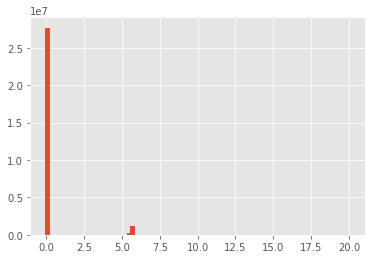

In [26]:
plt.bar(tolls_center, df_tolls_counts, align='center', width=width);

In [67]:
numerical_cols
df_num = df[]
df_num_p9 = df_num.quantile(0.25)
df_num_q3 = df_num.quantile(0.75)
df_num_iqr = df_num_q3 - df_num_q1
filter_num_outlier = ((df_num < (df_num_q1 - 1.5*df_num_iqr)) |
                      (df_num > (df_num_q3 + 1.5*df_num_iqr)))

In [72]:
filter_num_outlier.passenger_count.sum().compute()

2795206

In [71]:
df[filter_num_outlier.passenger_count].shape[0].compute()

2795206

In [57]:
with ProgressBar():
    df_num_q1 = df_num_q1.compute()
    df_num_q3 = df_num_q3.compute()
    df_num_iqr = df_num_iqr.compute()

[########################################] | 100% Completed |  1min  7.2s
[########################################] | 100% Completed |  1min  2.6s
[########################################] | 100% Completed |  1min  4.1s


In [64]:
df_num_iqr

passenger_count           1.00
trip_distance             2.41
fare_amount              11.00
extra                     0.50
mta_tax                   0.00
tip_amount                2.96
tolls_amount              0.00
improvement_surcharge     0.00
total_amount             12.94
dtype: float64

In [65]:
(df_num_q1 - 1.5*df_num_iqr).clip(0)

passenger_count          0.0
trip_distance            0.0
fare_amount              0.0
extra                    0.0
mta_tax                  0.5
tip_amount               0.0
tolls_amount             0.0
improvement_surcharge    0.3
total_amount             0.0
dtype: float64

In [66]:
df_num_q3

passenger_count           2.000000
trip_distance             3.470000
fare_amount              18.500000
extra                     1.000000
mta_tax                   0.500000
tip_amount                2.960000
tolls_amount              0.000000
improvement_surcharge     0.300000
total_amount             22.299999
Name: 0.75, dtype: float64

In [62]:
df_num_q3 + 1.7*df_num_iqr

passenger_count           3.700000
trip_distance             7.567000
fare_amount              37.200000
extra                     1.850000
mta_tax                   0.500000
tip_amount                7.992000
tolls_amount              0.000000
improvement_surcharge     0.300000
total_amount             44.297999
dtype: float64

##  Data istances with anomalous numerical variables (filtered out)

We will explore rows with negative numerical values or zero fare amount that were discarded from the data. 

Since the count of these trips is very small relative to the whole data set, it is a good idea to drop them to decrease sources of noise.

### Negative charges

These rows have been regarded as anomalous from the start of the analysis. 
They might have been recorded in the database to display a refund due to a variety of reasons like disputes, cancellations, incorrect charges, etc.

To back up this hypothesis we will dispay the payment type distribution and a scatter plot of distance vs trip duration in minutes.

As these isntances are relatively small, we can handle the analysis in memory.

In [27]:
with ProgressBar():
    df_neg = df_neg.compute()
    df_zero_fare = df_zero_fare.compute()
gc.collect();

[########################################] | 100% Completed |  2.2s
[########################################] | 100% Completed |  1.9s


* The payment type histogram shows that indeed most of these records are refunds, some of them due to disputes. 

* As plotted, most of these cases correspond to extremely short trips in time, in distance or both.

* Note that longest of these trips cluster at day-long trips (1,400 minutes).

* Around 20-30 of these trips may be actual trips with a correction on a given surcharge.

* No further validation will be performed due to time constraints (for exaple, looking for explantory variables). 

In [28]:
df_neg_trip_duration = df_neg.tpep_dropoff_datetime - df_neg.tpep_pickup_datetime
df_neg_trip_duration_mins = df_neg_trip_duration.dt.total_seconds()/60
df_neg.insert(loc=3,
              column='trip_duration_mins',
              value=df_neg_trip_duration_mins)

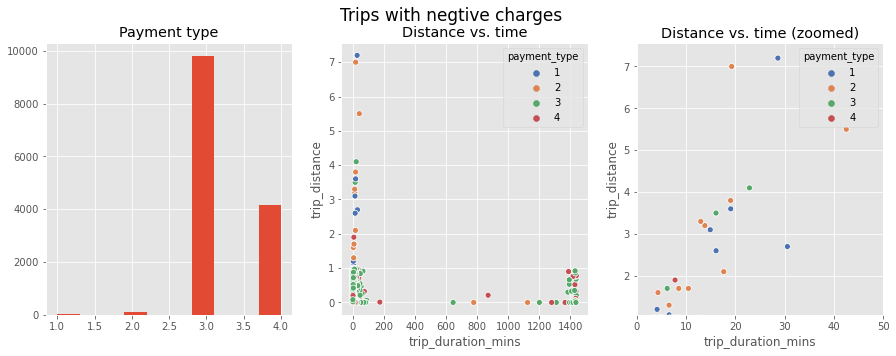

In [29]:
num_cols = 3
num_rows = 1
scale = 5
figsize = (num_cols * scale, num_rows * scale)
_, ax = plt.subplots(num_rows, num_cols, figsize=figsize)

plt.suptitle('Trips with negtive charges', size=17);

df_neg.payment_type.hist(ax=ax[0]);
ax[0].set_title('Payment type');

sns.scatterplot(data=df_neg,
                x='trip_duration_mins',
                y='trip_distance',
                hue=df_neg.payment_type.tolist(),
                legend='full',
                palette='deep',
                ax=ax[1]);
ax[1].legend(loc='best', 
             title='payment_type')

ax[1].set_title('Distance vs. time');

sns.scatterplot(data=df_neg,
                x='trip_duration_mins',
                y='trip_distance',
                hue=df_neg.payment_type.tolist(),
                palette='deep',
                ax = ax[2]);
ax[2].legend(loc='best', 
             title='payment_type')
ax[2].set_ylim(1.07)
ax[2].set_xlim(0, 50)
ax[2].set_title('Distance vs. time (zoomed)');

### Zero fare amount

* About a third of these instances do correspond to non-charged trips or trips with disputes.

* The remaining cases could correspond to free trips or errors while recording them.

In [30]:
df_zero_fare_trip_duration = df_zero_fare.tpep_dropoff_datetime - df_zero_fare.tpep_pickup_datetime
df_zero_fare_trip_duration_mins = df_zero_fare_trip_duration.dt.total_seconds()/60
df_zero_fare.insert(loc=3,
                    column='trip_duration_mins',
                    value=df_zero_fare_trip_duration_mins)

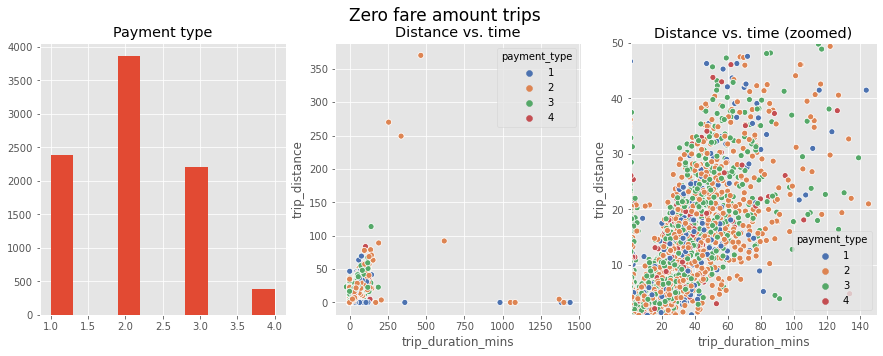

In [31]:
num_cols = 3
num_rows = 1
scale = 5
figsize = (num_cols * scale, num_rows * scale)
_, ax = plt.subplots(num_rows, num_cols, figsize=figsize)

plt.suptitle('Zero fare amount trips', size=17);

df_zero_fare.payment_type.hist(ax=ax[0]);
ax[0].set_title('Payment type');

sns.scatterplot(data=df_zero_fare,
                x='trip_duration_mins',
                y='trip_distance',
                hue=df_zero_fare.payment_type.tolist(),
                palette='deep',
                ax=ax[1]);
ax[1].legend(loc='best', 
             title='payment_type');
ax[1].set_title('Distance vs. time');

sns.scatterplot(data=df_zero_fare,
                x='trip_duration_mins',
                y='trip_distance',
                hue=df_zero_fare.payment_type.tolist(),
                palette='deep',
                ax=ax[2]);
ax[2].legend(loc='best', 
             title='payment_type');
ax[2].set_ylim(1, 50)
ax[2].set_xlim(1, 150)
ax[2].set_title('Distance vs. time (zoomed)');

* The vast majority of these trips do not include recorded tips.

* Due to these imbalance, it might be better to plan for a separate analysis for these instances. 

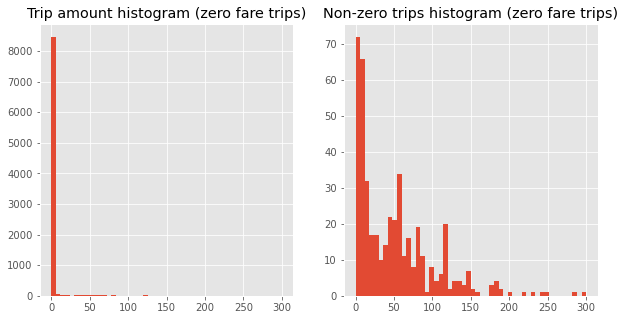

In [32]:
num_cols = 2
num_rows = 1
scale = 5
figsize = (num_cols * scale, num_rows * scale)
_, ax = plt.subplots(num_rows, num_cols, figsize=figsize)
df_zero_fare.tip_amount.hist(bins=50, ax=ax[0]);
ax[0].set_title('Trip amount histogram (zero fare trips)');
df_zero_fare[df_zero_fare.tip_amount > 0].tip_amount.hist(bins=50, ax=ax[1]);
ax[1].set_title('Non-zero trips histogram (zero fare trips)');

In [33]:
del df_zero_fare, df_neg
gc.collect();

#  Exploration of date data

In [34]:
(df[datetime_cols[1]] - df[datetime_cols[0]]).head()

0   0 days 00:14:09
1   0 days 00:11:01
2   0 days 00:10:08
3   0 days 08:10:06
4   0 days 00:09:55
dtype: timedelta64[ns]

## Exploration of location data

In [20]:
def get_lat_lon(sf):
    content = []
    for sr in sf.shapeRecords():
        shape = sr.shape
        rec = sr.record
        loc_id = rec[shp_dic['LocationID']]
        
        x = (shape.bbox[0]+shape.bbox[2])/2
        y = (shape.bbox[1]+shape.bbox[3])/2
        
        content.append((loc_id, x, y))
    return pd.DataFrame(content, columns=["LocationID", "longitude", "latitude"])

In [21]:
sf = shapefile.Reader(str(DATA_DIR / 'taxi_zones.shp'))
fields_name = [field[0] for field in sf.fields[1:]]
shp_dic = dict(zip(fields_name, list(range(len(fields_name)))))
attributes = sf.records()
shp_attr = [dict(zip(fields_name, attr)) for attr in attributes]

df_loc = pd.DataFrame(shp_attr).join(get_lat_lon(sf).set_index("LocationID"), on="LocationID")
df_loc.head()

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,longitude,latitude
0,1,0.116357,0.000782,Newark Airport,1,EWR,9.366817e+05,190522.130278
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,1.033536e+06,161853.982300
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,1.027136e+06,254730.010849
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,9.904240e+05,203100.040432
4,5,0.092146,0.000498,Arden Heights,5,Staten Island,9.321332e+05,139954.541936


## Data Science Take Home Test
Every month New York City releases data about trips taken in NYC taxis. This data can be found here: (NYC Taxi & Limousine Commission - Trip Record Data) and is described by the data dictionary (https://www1.nyc.gov/assets/tlc/downloads/pdf/data_dictionary_trip_records_yellow.pdf)

A new ride sharing company is your client. They are looking to start up a rival service to Uber or Lyft in NYC and are interested in using the Taxi Data to get insight into the transportation sector in New York. They have tasked you to get to know the data and start to build some simple models off of it.

In the following tasks, you should focus on yellow cab data from the months of March, June, and November in 2017. Feel free to use more than that, but those months should be the minimum.

Feel free to use any programming language and libraries of your choosing. Results should be delivered as a either a GitHub repo with the code and results (preferred), a zipped directory of code and results, or Colab Notebook(s). Note: If you post your work online, please ensure there are no references to CARTO or links to this homework.

You should spend approximately 4 hours on these tasks. Try to document your thought process as much as possible.

You have three tasks:

### Data exploration and cleaning

* Download and assess the data
* Identify and document any issues with the data
* Document how you resolved these issues

### Data Summary

Create a brief report that summarizes the core features of the data and calls out interesting trends, etc. This can be in the form of a notebook-like document (Jupyter, RMarkdown, etc.) or a slide deck. The audience for this should be other data scientists who need to understand that dataset.

### Model Building

The client is launching a new ride sharing program in New York similar to Uber or Lyft. At the end of each trip they want their app to suggest a tip amount to the rider. The company has not acquired any of their own data yet, so they have tasked you with producing a model based off of the taxi data. This model should predict the likely tip amount for a trip based on the other trip attributes. You can assume that the ride sharing company can provide data that has the same attributes as the taxi data for each trip.

In building the model, consider the following requirements:

* The model should be built from the taxi dataset. You can supplement the taxi data with external datasets, but this is not a requirement.
* Document your choice of model / algorithm, discussing why you chose it over alternatives.
    * Document how you assess your models performance.
    * Discuss any limitations or caveats of the model which might be an issue in implementing it.
    * Discuss how you might improve your model going forward.
* Discuss how you might turn this model in to an API the company can use.
